In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from time import time
from scipy import stats

from numba import jit

# Problem 1: arithmetic Asian option

For MC calculations with millions of samples, we will again be using `numba` for high-performance calculation. In particular, we cannot use the `scipy` implementation of the Gaussian CDF. We will then use the Beasley-Springer-Moro algorithm (which we also used in HW4) as described in here: https://www.quantstart.com/articles/Statistical-Distributions-in-C/

Also, notice that we can write $d_2 = d_1 - \hat{\sigma}\sqrt{T}$, which we can use for faster computation.

## a) Analytical price for geometric Asian option

In [6]:
@jit(nopython=True)
def normal_cdf(x):
    """
    Returns F(x) = Prob(X<x) for X ~ N(0,1) in the Beasley-Springer-Moro approximation
    """
    k = 1.0/(1.0 + 0.2316419*x);
    k_sum = k*(0.319381530 + k*(-0.356563782 + k*(1.781477937 + k*(-1.821255978 + 1.330274429*k))))

    if x >= 0:
        return (1.0 - (1.0/np.sqrt(2*np.pi))*np.exp(-0.5*x*x) * k_sum)
    else:
        return 1.0 - normal_cdf(-x)


In [7]:
@jit(nopython=True)
def geom_asian_call_price(S0, K, r, sigma, T):
    """
    Returns price for geometric Asian option taken over N+1 steps
    """
    
    N = 252.0 * T 
    sigma_hat = sigma * np.sqrt((2*N+1)/(6*(N+1)))
    rho = 0.5 * (r - 0.5*sigma**2 + sigma_hat**2)
    
    d1 = 1.0/(np.sqrt(T)*sigma_hat) * (np.log(S0/K) + (rho+sigma_hat**2/2)*T)
    d2 = d1 - sigma_hat*np.sqrt(T)
    
    price = np.exp(-r*T) * (S0 * np.exp(rho*T)*normal_cdf(d1) - K * normal_cdf(d2))
    return price

In [8]:
p_g = geom_asian_call_price(S0=100.0, K=100.0, r=0.03, sigma=0.3, T=5.0)
print("Geometric Asian option price (exact): %.2f" % p_g)

Geometric Asian option price (exact): 15.17


## b) Standard MC for arithmetic Asian option

For the Monte-Carlo simulations below, since we want to keep track of the calculation time, we wrap the MC functions into a time tracker (as we also did in HW4).

In [5]:
def time_function(func):
    """
    Take a function returning a price and a standard error, and also add the
    runtime duration to the return arguments 
    """
    def timed(*args, **kwargs):
        t0 = time()
        opt_value, opt_se = func(*args, **kwargs)
        duration = time() - t0
        return opt_value, opt_se, duration
    return timed


We store the running sum in a variable $X$:
$$X_k = \sum_{i=0}^k S_{t_i}$$
and then average (with $1/(N+1)$) in the end for computing the payoff. Since we need to calculate an exponential at every iteration (for $S_t = \exp(\ln S_t)$) the calculation can be a bit slow.

In [6]:
@jit(nopython=True)
def _arith_asian_call_price_mc(S0, K, r, sigma, T, n_sims=1000):
    
    # We use the codes from HW4 for the div=0 case
    n_steps = int(252*T)
    dt = T/n_steps
    nudt = (r - 0.5*sigma**2)*dt
    sigsdt = sigma * np.sqrt(dt)
    
    sum_CT, sum_CT2 = 0, 0
    
    for _ in range(n_sims):
        S = S0
        X = S
        for i in range(n_steps):
            # expensive calculation of exponential at every iteration
            S = S*np.exp(nudt + np.random.randn() * sigsdt)
            X += S
            
        # values at maturity
        ST = X/(n_steps+1)
        CT = max(0, ST-K)
        
        sum_CT += CT
        sum_CT2 += CT**2
    
    opt_value = np.exp(-r*T) * (sum_CT/n_sims)
    opt_std = np.exp(-r*T) * 1/(n_sims-1) * (sum_CT2 - (1/n_sims)* (sum_CT)**2)
    opt_se = opt_std/np.sqrt(n_sims)
    
    return opt_value, opt_se

arith_asian_call_price_mc = time_function(_arith_asian_call_price_mc)

# run once to compile
_, _ = _arith_asian_call_price_mc(S0=100.0, K=100.0, r=0.03, sigma=0.2, T=1.0, n_sims=10)


In [7]:
p_a_sim, err, duration = arith_asian_call_price_mc(S0=100.0, K=100.0, r=0.03, sigma=0.3, T=5.0, n_sims=1000000)

In [8]:
print("Arithmetic Asian option (Monte-Carlo, 1 million samples)")
print("> Price: %.2f" % p_a_sim)
print("> Error: %.2f" % err)
print("> Calculation time: %.1f seconds" % duration)

Arithmetic Asian option (Monte-Carlo, 1 million samples)
> Price: 17.47
> Error: 1.10
> Calculation time: 58.2 seconds


Assuming a normal distribution for the price, the 95% confidence interval will be $[\hat{x} - 1.96 \sigma, \hat{x} + 1.96 \sigma]$ or:

In [9]:
(round(p_a_sim-1.96*err,2), round(p_a_sim+1.96*err,2))

(15.32, 19.61)

This result makes sense - it is more expensive than the geometric counterpart, since arithmetic averages are higher or equal to geometric ones, thus the arithmetic option is more in-the-money than a geometric one, and is thus more valuable. However, the error is still very high even at a million MC samples.

## c) Standard MC for geometric Asian option

We want to compute the MC approximation for $(\bar S - K)^+$, where

$$\bar S \equiv \left(\prod_{i=0}^N S_{t_i} \right)^{1/(N+1)}$$

Notice that it is easier (and computationally cheaper) to take the log of both sides and instead compute

$$\bar{S} = e^{X/(N+1)}$$ 

where $X \equiv \sum_{i=0}^N \log S_{t_i}$. Thus, at every time step, we can just update $X$ and take the exponential in the end. Specifically,

$$\log S_{i+1} = \log S_i + (r-\sigma^2/2)\Delta t + \sigma \sqrt{\Delta t} \epsilon_i,\qquad \epsilon_i \sim N(0,1)$$

$$X_{i+1} = X_i + \log S_{i+1}$$

In [10]:
@jit(nopython=True)
def _geom_asian_call_price_mc(S0, K, r, sigma, T, n_sims=1000):
    
    # We use the codes from HW4 for the div=0 case
    n_steps = int(252*T)
    dt = T/n_steps
    nudt = (r - 0.5*sigma**2)*dt
    sigsdt = sigma * np.sqrt(dt)
    
    sum_CT, sum_CT2 = 0, 0
    
    for _ in range(n_sims):
        lnS = np.log(S0)
        X = lnS
        for i in range(n_steps):
            lnS += nudt + np.random.randn() * sigsdt
            X += lnS
            
        # values at maturity
        ST = np.exp(X/(n_steps+1))
        CT = max(0, ST-K)
        
        sum_CT += CT
        sum_CT2 += CT**2
    
    opt_value = np.exp(-r*T) * (sum_CT/n_sims)
    opt_std = np.exp(-r*T) * 1/(n_sims-1) * (sum_CT2 - (1/n_sims)* (sum_CT)**2)
    opt_se = opt_std/np.sqrt(n_sims)
    
    return opt_value, opt_se

geom_asian_call_price_mc = time_function(_geom_asian_call_price_mc)

# run once to compile
_, _ = _geom_asian_call_price_mc(S0=100.0, K=100.0, r=0.03, sigma=0.2, T=1.0, n_sims=10)


Let us compare this with the analytical result, to ensure we are on the right track:

In [11]:
p_g_sim, err, duration = geom_asian_call_price_mc(S0=100.0, K=100.0, r=0.03, sigma=0.3, T=5.0, n_sims=1000000)

In [12]:
print("Geometric Asian option (Monte-Carlo, 1 million samples)")
print("> Price: %.2f" % p_g_sim)
print("> Error: %.2f" % err)
print("> Calculation time: %.1f seconds" % duration)

Geometric Asian option (Monte-Carlo, 1 million samples)
> Price: 15.15
> Error: 0.82
> Calculation time: 36.0 seconds


The price matches the analytical one within the standard error.

## d) Correlation coefficient for arith. and geom. Asian options

We will adapt the codes above to return not only the averages, but also the Monte-Carlo samples.

Basically, we add a vector which keeps the values of the prices and returns it

In [13]:
@jit(nopython=True)
def both_asian_call_price_mc_samples(S0, K, r, sigma, T, n_sims=1000):
    
    n_steps = int(252*T)
    dt = T/n_steps
    nudt = (r - 0.5*sigma**2)*dt
    sigsdt = sigma * np.sqrt(dt)
    
    Y_list = [] # keeps value for arithmetic option
    X_list = [] # keeps value for geometric option
    for _ in range(n_sims):
        S = S0
        lnS = np.log(S0)
        X = S
        Y = lnS
        for i in range(n_steps):
            # expensive calculation of exponential at every iteration
            S = S*np.exp(nudt + np.random.randn() * sigsdt)
            X += S
            Y += np.log(S)
            
        # values at maturity
        ST_arit = X/(n_steps+1)
        ST_geom = np.exp(Y/(n_steps+1))
        CT_arit = np.exp(-r*T) * max(0, ST_arit-K)
        CT_geom = np.exp(-r*T) * max(0, ST_geom-K)
        
        X_list.append(CT_arit)
        Y_list.append(CT_geom)
        
        
    return np.array(X_list), np.array(Y_list)

# run once to compile
_, _ = both_asian_call_price_mc_samples(S0=100.0, K=100.0, r=0.03, sigma=0.2, T=1.0, n_sims=10)

In [29]:
X, Y = both_asian_call_price_mc_samples(S0=100.0, K=100.0, r=0.03, sigma=0.3, T=5.0, n_sims=10000)

Check that these give values on the same order of magnitude as before:

In [30]:
round(np.mean(X),2), round(np.mean(Y), 2)

(17.59, 15.25)

Run linear regression:

In [31]:
import scipy.stats 
b = scipy.stats.linregress(X, Y).slope

In [32]:
print("Slope coefficient: ", round(b,3))

Slope coefficient:  0.859


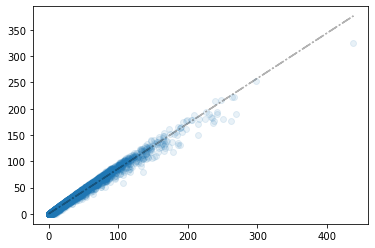

In [33]:
plt.scatter(X, Y, alpha=0.1)
plt.plot(X, b*X, color='black', linestyle='-.', alpha=0.3)
plt.show()

## e) Error of pricing a geometric Asian option via MC

Using the values calculated for the vector $Y$ above:

In [37]:
print("Standard error for the geometric price: %.2f" % (np.std(Y-p_g)/np.sqrt(len(Y))))

Standard error for the geometric price: 0.27


## f) Error of pricing an arithmetic Asian option via control variate MC

In [38]:
print("Standard error for the control-variate price: %.2f" % (np.std(X - b*(Y-p_g))/np.sqrt(len(Y))))

Standard error for the control-variate price: 0.08


### Increasing to a million samples

In [39]:
%%time
X, Y = both_asian_call_price_mc_samples(S0=100.0, K=100.0, r=0.03, sigma=0.3, T=5.0, n_sims=1000000)

Wall time: 1min 15s


In [40]:
print("Standard error for the geometric price: %.2f" % (np.std(Y-p_g)/np.sqrt(len(Y))))

Standard error for the geometric price: 0.03


In [41]:
print("Standard error for the control-variate price: %.2f" % (np.std(X - b*(Y-p_g))/np.sqrt(len(Y))))

Standard error for the control-variate price: 0.01


We see an obvious reduction in all errors. For completeness, we also display below the expected price for the arithmetic option:

In [44]:
price_arit_control = np.mean(X - b*(Y-p_g))
print("Price for arithmetic option: %.2f" % price_arit_control)

Price for arithmetic option: 17.49


# Problem 2: Heston model

For this problem, we mostly follow Chapter 10 of "The Heston Model and Its Extensions in Matlab and C#" (2013), since the problem statement also does so (eg. with the sign convention for time).

## a) Discretization

Our goal is to discretize the following PDE:

$$ \frac{\partial U}{\partial t} = \frac 12 v S^2 \frac{\partial^2 U}{\partial S^2} + \rho \sigma v S \frac{\partial^2 U}{\partial v \partial S} + \frac 12 \sigma^2 v \frac{\partial^2 U}{\partial v^2} - r U + (r-q) S \frac{\partial U}{\partial S} + \kappa (\theta - v) \frac{\partial U}{\partial v}$$

Here, $t$ denotes **time to maturity**, i.e. $T-t$ in usual conventions. Because of this, maturity is now at $t=0$.

We consider the setup of the problem and the notation defined in the problem statement, that is

$$U(t=n \Delta t, S = i \Delta S, v = j \Delta v) =: U^n_{i,j}$$

where $n \in \{0, \ldots, N_T\}$, $i \in \{0, \ldots, N_S\}$ and $j \in \{0, \ldots, N_V\}$.

Then, time-derivatives are forward derivatives and all others are centered:

$$\frac{\partial U}{\partial t} \approx \frac{U^{n+1}_{i,j} - U^n_{i, j}}{\Delta t}$$
$$\frac{\partial U}{\partial S} \approx \frac{U^n_{i+1, j} - U^n_{i-1, j}}{2\Delta S}$$
$$\frac{\partial U}{\partial v} \approx \frac{U^n_{i, j+1} - U^n_{i, j-1}}{2\Delta v}$$

For the second-order derivatives, an important result will be the centered cross-derivative. For a function $u(x,y)$ with $u_{i,j} \equiv u(x=i\Delta x, y=j\Delta y)$ one has

$$\frac{\partial ^2 u}{\partial x \partial y} \approx \frac{u_{i+1,j+1} - u_{i+1, j-1} - u_{i-1, j+1} + u_{i-1, j-1}}{4\Delta x\Delta y}$$

From this, we can write the relevant second-order derivatives as:

$$\frac{\partial^2 U}{\partial S^2} \approx \frac{U^n_{i+1,j} - 2 U^n_{i,j} + U^n_{i-1,j}}{(\Delta S)^2}$$
$$\frac{\partial^2 U}{\partial v^2} \approx \frac{U^n_{i, j+1} - 2 U^n_{i, j} + U^n_{i, j-1}}{(\Delta v)^2}$$
$$\frac{\partial ^2 U}{\partial v \partial S} \approx \frac{U^n_{i+1,j+1} - U^n_{i+1, j-1} - U^n_{i-1, j+1} + U^n_{i-1, j-1}}{4\Delta v\Delta S}$$

## b) Plugging back into the PDE

Let 
$$S_i \equiv i \Delta S, \qquad v_j \equiv j \Delta v$$

To avoid clutter, since all $U$'s in the right-hand side are evaluated at $n$, we omit the superscript $n$. Then, plugging the derivatives above back into the PDE yields

$$\begin{align}
\frac{U^{n+1}_{i,j} - U^n_{i,j}}{\Delta t} &= \frac 12 v_j S_i^2 \left(\frac{U_{i+1,j} - 2 U_{i,j} + U_{i-1,j}}{\Delta S^2} \right) + \rho \sigma v_j S_i \left( \frac{U_{i+1,j+1} - U_{i+1,j-1} - U_{i-1,j+1} + U_{i-1,j-1}}{4 \Delta S \Delta v} \right) + \\
&+ \frac 12 \sigma^2 v_j \left( \frac{U_{i,j+1}-2U_{i,j} + U_{i,j-1}}{\Delta v^2}\right) - rU_{i,j} + (r-q)S_i \left(\frac{U_{i+1,j} - U_{i-1,j}}{2\Delta S} \right) + \kappa (\theta-v_j) \left(\frac{U_{i, j+1} - U_{i, j-1}}{2\Delta v} \right)
\end{align}$$

Simplifying, yields

$$\boxed{\begin{align}
U^{n+1}_{i,j} &= pU^n_{i,j} \\
&+p_i^{(+)} U^n_{i+1,j} + p_i^{(-)} U^n_{i-1,j} \\
&+p_j^{(+)} U^n_{i,j+1} + p_j^{(-)} U^n_{i,j-1}\\
&+p_{ij} (U^n_{i+1,j+1} - U^n_{i+1,j-1} - U^n_{i-1,j+1} + U^n_{i-1,j-1}) \\
\end{align}}$$

where
$$p = 1 - r \Delta t -\frac{ v_j S_i^2 \Delta t}{\Delta S^2} - \frac{\sigma^2 v_j \Delta t}{\Delta v^2}$$
$$p_i^{(\pm)} = \frac{S_i \Delta t}{2 \Delta S} \left(\frac{v_j S_i}{\Delta S} \pm (r-q) \right)$$
$$p_j^{(\pm)} = \frac{\Delta t}{2 \Delta v} \left(\frac{\sigma^2 v_j}{\Delta v} \pm \kappa(\theta - v_j)\right)$$
$$p_{ij} = \frac 14 \frac{\rho \sigma v_j S_i \Delta t}{\Delta S \Delta v}$$

Equivalently we can just substitute $S_i = i \Delta S$ and $v_j = j \Delta v$ in the expressions above, to get

$$p = 1 - r \Delta t - j \Delta v i^2 \Delta t - \frac{\sigma^2 j  \Delta t}{\Delta v}$$
$$p_i^{(\pm)} = \frac{i \Delta t}{2} \left(i j \Delta v \pm (r-q) \right)$$
$$p_j^{(\pm)} = \frac{\Delta t}{2 \Delta v} \left(j \sigma^2 \pm \kappa(\theta - j \Delta v)\right)$$
$$p_{ij} = \frac 14 {\rho \sigma i j\Delta t}$$

(for the last one, we notice that the classroom notes and the original paper probably have a typo, since they omit $\rho$)

## c) Boundary conditions

Since we consider $U$ to be the price of an European call option with strike $K$, the boundary conditions on the variables $S$ and $t$ are the same as those in the Black-Scholes case. 

There are 5 boundary conditions to consider. We will make them explicit in both the continuous and discretized versions.

### Continuous version

1) At maturity: payoff condition
$$U(t=0, S, v) = \max(S - K, 0)$$ 

2) At $S = 0$: fully OTM option
$$U(t, S=0, v) = 0$$

3) At $S \to \infty$: option becomes as valuable as the stock itself
$$\lim_{S\to\infty} \frac{\partial U}{\partial S} = 1$$
If we fix a maximum, finite $S_{max}$ then this translates to
$$\left.\frac{\partial U}{\partial S} \right|_{S=S_{max}} = 1$$
4) At $v \to \infty$: option prices are bounded by the spot value, and increase monotonically with volatility (positive vega). As the volatility grows to infinity, the price must converge to the spot
$$\lim_{v\to\infty} U(t,S,v) = S$$
Again, if we fix a maximum, finite $v_{max}$ then this translates to
$$U(t,S,v_{max}) = S$$
5) At $v \to 0$: we consider the PDE if we formally set $v=0$. Below, all derivatives are evaluated at this point.

$$\frac{\partial U}{\partial t} = - rU + (r-q) S \frac{\partial U}{\partial S} + \kappa \theta \frac{\partial U}{\partial v}$$

### Discretized version

1) $U^0_{i,j} = \max(S_i - K, 0)$

2) $U^n_{0,j} = 0$

3) $U^n_{N_S, j} = U^n_{N_S-1, j} + (S_{N_S} - S_{N_S-1})$ where $S_{N_S} = S_{max}$

4) $U^n_{i, N_V} = S_i$

5) For the last condition, we notice that since we are at the $v=0$ boundary, we cannot calculate a centered difference for the $\partial U/\partial v$ derivative; instead we use a forward difference. For the $S$ derivative we can make it centered, though:
$$\frac{U^{n+1}_{i,0} - U^n_{i,0}}{\Delta t} = - r U_{i,0}^n + (r-q) S_i \frac{U^n_{i+1,0} - U^n_{i-1,0}}{2\Delta S} + \kappa \theta \frac{U^n_{i,1} - U^n_{i,0}}{\Delta v}$$

or, solving for $U^{n+1}_{i,0}$:

$$U^{n+1}_{i,0} = U^n_{i,0} \left(1 - r\Delta t - \frac{\kappa \theta \Delta t}{\Delta v} \right) + U^n_{i,1} \frac{\kappa \theta \Delta t }{\Delta v} + (U^n_{i+1,0} - U^n_{i-1,0}) \frac{(r-q)S_i \Delta t}{2\Delta S}$$

## d) Solving the PDE

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from time import time
from scipy import stats

from numba import jit

For the evolution equations / boundary conditions above, we can both use the simplified versions (of the form $\sum_{i,j} a_{ij} U_{ij}^n$) or more simply calculate each derivative term by itself without joining similar terms. Below, inside the function `heston_pde`, we add the two options.

The `location` parameter is just an artifice to locate the $i,j$ values for the initial conditions. If we set `NS = 100` and `location = 10`, for an initial spot of 200, then it means that $\Delta S = 200/10 = 20$, $S_{max} = 100 \times 20 = 2000$ and the original spot will be element `S[10]`, corresponding to the location.

**We could not figure out how to remove numerical instabilities**. The option price quickly diverges due to oscillations, especially when $N_T$ grows larger. Below we show examples of the price profile for a few selected ranges:

In [540]:
@jit(nopython=True)
def heston_pde(S0, K, r, q, V0, kappa, theta, sigma, rho, T, NT=1000, NS=1000, NV=1000, location=10):
    
    # constants
    ds = S0/location
    dv = V0/location
    Smax = NS * ds
    Vmax = NV * dv
    assert Smax > S0, "NS needs to be higher"
    assert Vmax > V0, "NV needs to be higher"
    dt = T/NT
    
    # price matrix and boundary condition @t=T
    S = np.arange(0, Smax+ds, ds)
    v = np.arange(0, Vmax+ds, dv)
    
    # U will be updated at every iteration from U^{n} -> U^{n+1}
    U = np.zeros((NS+1, NV+1))
    
    # impose boundary condition (1) (payoff)
    for i in range(NS+1):
        for j in range(NV+1):
            U[i, j] = max(S[i]-K,0)
    
    # create list to store slices of U at every time, for debugging purposes
    U_list = []
    
    # evolve in time, and at each step, impose boundary conditions
    for n in range(NT):

        # boundary conditions 2 (U(S=0) = 0) and 3 (U(S=Smax) = Smax)
        for j in range(NV):  
            U[0,  j] = 0
            U[NS, j] = U[NS-1, j] + (S[NS] - S[NS-1]) 
        
        # boundary condition 4 (U(S,v=vmax) = S)
        for i in range(NS+1): 
            U[i, NV] = S[i]
            
        # boundary condition 5 (at v = 0)
        u = U.copy()
        for i in range(1,NS): 
            
            # method 1: explicitly add all finite diferences
            dUdS = (u[i+1,0] - u[i-1,0])/(2 *ds)
            dUdV = (u[i,1] - u[i,0])/dv
            U[i,0] = u[i,0] + dt * (- r * u[i,0] + (r-q) * S[i] * dUdS + kappa * theta * dUdV)
            
            # method 2: use simplified expression
            # U_new[i,0] = (u[i,0] * (1 - r*dt - kappa * theta * dt/dv) + u[i,1] * kappa * theta * dt/dv +
            #        (u[i+1,0] - u[i-1,0]) * (r-q) * S[i] * dt/(2 * ds))
        
        U_list.append(U.copy())

        # evolution
        u = U.copy()
        for i in range(1, NS): 
            for j in range(1, NV): 
                
                # method 1
                d2UdS2  = (u[i+1,j] - 2 * u[i,j] + u[i-1,j])/(ds**2)
                d2UdVdS = (u[i+1,j+1] - u[i+1, j-1] - u[i-1,j+1] + u[i-1,j-1])/(4*ds*dv)
                d2UdV2  = (u[i,j+1] - 2 * u[i,j] + u[i,j-1])/(dv**2)
                dUdS    = (u[i+1,j] - u[i-1,j])/(2*ds)
                dUdV    = (u[i,j+1] - u[i,j-1])/(2*dv)
                
                U[i,j] = u[i,j] + dt * (0.5 * (v[j]*S[i]**2) * d2UdS2 + 
                                            rho * sigma * v[j] * S[i] * d2UdVdS + 
                                            0.5 * sigma**2 * v[j] * d2UdV2 -
                                            r * u[i,j] + 
                                            (r-q)*S[i]*dUdS + 
                                            kappa * (theta - v[j]) * dUdV)
                # method 2
                #p       = 1 - r* dt - v[j] * S[i]**2 * dt/(ds**2) - sigma**2 * v[j] * dt/(dv**2)
                #pi_plus = S[i]*dt/(2*ds) * (v[j]*S[i]/ds + (r-q))
                #pi_mins = S[i]*dt/(2*ds) * (v[j]*S[i]/ds - (r-q))
                #pj_plus = dt/(2*dv) * (sigma**2 * v[j]/dv + kappa * (theta-v[j]))
                #pj_mins = dt/(2*dv) * (sigma**2 * v[j]/dv - kappa * (theta-v[j]))
                #pij     = rho * sigma * v[j] * S[i] * dt/(4 * ds * dv)
                
                #U_new[i,j] = (p * u[i,j] +
                #pi_plus * u[i+1,j] + pi_mins * u[i-1,j] + 
                #pj_plus * u[i,j+1] + pj_mins * u[i,j-1] + 
                #pij * (u[i+1, j+1] - u[i-1, j+1] - u[i+1, j-1] + u[i-1, j-1]))
        
    return U, U_list

# run once to compile
U, _ = heston_pde(S0=100.0, K=100.0, r=0.05, q=0.03, V0=0.3, kappa=0.0, #6.21,
                  theta=0.36, sigma=0.002, rho=-0.7, T=1.0,
            NT=3, NS=3, NV=3, location=1)

### Very small $N_T$:

In [598]:
loc = 3
U, U_list = heston_pde(S0=100.0, K=100.0, r=0.05, q=0.03, V0=0.3, kappa=6.21, theta=0.36, sigma=0.2, rho=-0.7, T=1.0,
            NT=4, NS=30, NV=20, location=loc)
print("Price:", U[loc,loc])

Price: 16.87109490760643


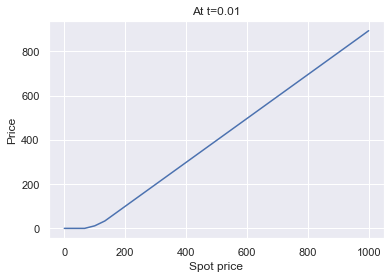

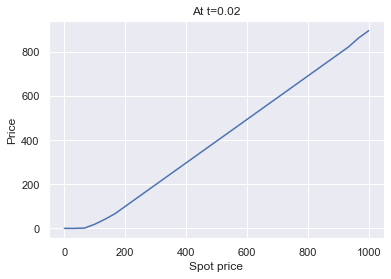

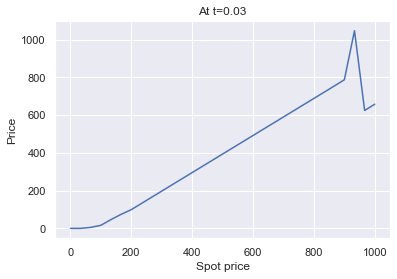

In [592]:
for t in [1, 2, 3]:
    plt.plot(U[:,-1], U_list[t][:,loc])
    plt.title(f"At t={round(t/100,2)}")
    plt.xlabel("Spot price")
    plt.ylabel("Price")
    plt.show()

### Higher  $N_T$:

In [593]:
loc = 3
U, U_list = heston_pde(S0=100.0, K=100.0, r=0.05, q=0.03, V0=0.3, kappa=6.21, theta=0.36, sigma=0.2, rho=-0.7, T=1.0,
            NT=10, NS=100, NV=100, location=loc)
print("Price:", U[loc,loc])

Price: 15.981851446027855


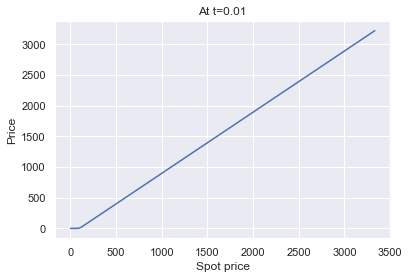

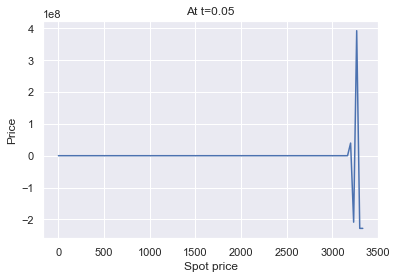

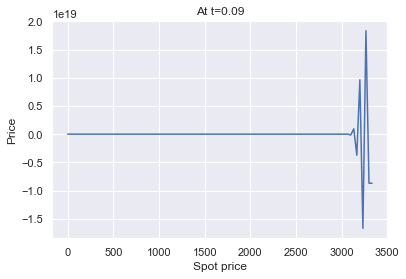

In [594]:
for t in [1, 5, 9]:
    plt.plot(U[:,-1], U_list[t][:,loc])
    plt.title(f"At t={round(t/100,2)}")
    plt.xlabel("Spot price")
    plt.ylabel("Price")
    plt.show()

### Even higher  $N_T$:

In [595]:
loc = 3
U, U_list = heston_pde(S0=100.0, K=100.0, r=0.05, q=0.03, V0=0.3, kappa=6.21, theta=0.36, sigma=0.2, rho=-0.7, T=1.0,
            NT=100, NS=100, NV=100, location=loc)
print("Price:", U[loc,loc])

Price: -1.2834718963353202e+107


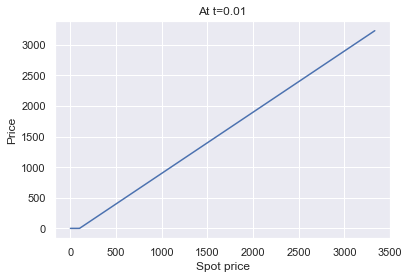

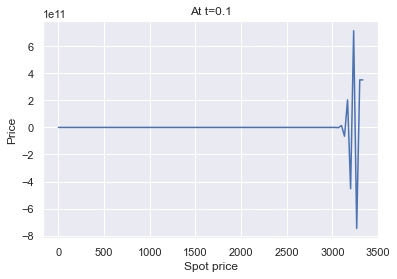

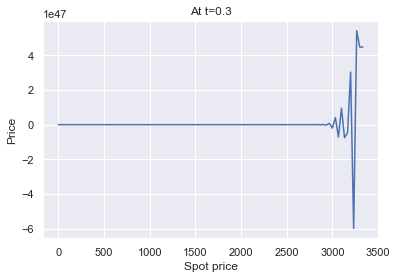

In [596]:
for t in [1, 10, 30]:
    plt.plot(U[:,-1], U_list[t][:,loc])
    plt.title(f"At t={round(t/100,2)}")
    plt.xlabel("Spot price")
    plt.ylabel("Price")
    plt.show()

### Conclusion

As we see, there is clearly an optimal setup for the choices of $N_T, N_S$ and $N_V$ to avoid instabilities, but most of the scenarios we tried are still unstable.

## e) Monte-Carlo

For the Monte-Carlo method, we will use the **full trancation** method employed in HW4. Letting $x^+ \equiv \max(x,0)$ this amounts to

$$\begin{cases}
\ln S_{t+\Delta t} &= \ln S_t + \left(r - \frac{1}{2}  V_t\right)\Delta t + \sqrt{V_t} \Delta W_t\\
\tilde{V}_{t+\Delta t} &= \tilde{V}_t - \kappa \Delta t (\tilde{V}(t) - \bar V)^+ + \sigma \sqrt{(\tilde{V}_t)^+} \Delta Z_t\\
V_{t+\Delta t} &= (\tilde{V}_{t+\Delta t})^+
\end{cases}$$

We copy the code verbatim from HW4, but: (1) removing the comparison with a theoretical base value (2) adding a dividend yield to the first equation: $r \mapsto r - q$ 

In [67]:
@jit(nopython=True)
def _heston_call(S0, K, r, q, V0, kappa, theta, sigma, rho, T, n_steps, n_sims, model=None):
    
    identity = lambda x: x
    positive = lambda x: max(x,0)
    module   = lambda x: abs(x)
    
    if model == 'absorption':
        f1, f2, f3 = positive, positive, positive
    elif model == 'reflection':
        f1, f2, f3 = module, module, module
    elif model == 'higham_mao':
        f1, f2, f3 = identity, identity, module
    elif model == 'partial_truncation':
        f1, f2, f3 = identity, identity, positive
    elif model == 'full_truncation':
        f1, f2, f3 = identity, positive, positive
    else:
        raise Exception("Invalid model")
    
    dt = T/n_steps    
    sum_CT, sum_CT2, mse = 0, 0, 0
    
    for _ in range(n_sims):
        lnS = np.log(S0)
        V = V0
        Vtilde = V0

        for i in range(n_steps):
            
            # correlated Gaussians
            X1 = np.random.randn()
            X2 = rho*X1 + np.sqrt(1-rho**2)*np.random.randn()
            
            # Brownians dZ, dW
            dZ = np.sqrt(dt)*X1
            dW = np.sqrt(dt)*X2
            
            # evolving the vol and spot
            lnS = lnS + (r - q - V/2)*dt + np.sqrt(V)*dW
            Vtilde = f1(Vtilde) - kappa * dt * (f2(Vtilde) - theta) + sigma*np.sqrt(f3(Vtilde)) * dZ
            V = f3(Vtilde)

        ST = np.exp(lnS)

        # payoff
        CT = max(0, ST-K)

        sum_CT += CT
        sum_CT2 += CT**2
    
    opt_value = np.exp(-r*T) * (sum_CT/n_sims)
    opt_std = np.exp(-r*T) * 1/(n_sims-1) * (sum_CT2 - (1/n_sims)* (sum_CT)**2)
    opt_se = opt_std/np.sqrt(n_sims)
    
    return opt_value, opt_se

heston_call = time_function(_heston_call)


### Sanity check: bring down to Black-Scholes case
Do this by setting $\kappa=0$ and $\sigma=0$, which makes $V_t = V_0 = \mathrm{const}$ as the square of the asset's volatility

In [64]:
price, err, duration = heston_call(S0=100.0, K=100.0, r=0.01, V0=0.4**2, kappa=0, theta=0.0, sigma=0.0, rho=-0.7, T=1.0,
               n_steps=500, n_sims=10**6, model='full_truncation')

In [65]:
print("> Price: %.2f" % price)
print("> Error: %.2f" % err)

> Price: 16.31
> Error: 0.92


Compare this to the Black-Scholes formula, eg. in https://www.mystockoptions.com/black-scholes.cfm?ticker=&s=100&x=100&t=1&r=1%25&v=40%25&calculate=Calculate -> theoretical result is 16.275, so we are within error margins. 

### Calculate for requested data

In [68]:
price, err, duration = heston_call(S0=100.0, K=100.0, r=0.05, q=0.03, V0=0.3, kappa=6.21, theta=0.36, sigma=0.2, rho=-0.7, T=1.0,
               n_steps=500, n_sims=2*10**6, model='full_truncation')

<ipython-input-67-1bf35d470bb7>:29: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(n_steps):


In [69]:
print("European Call in Heston model (Monte-Carlo, 2 million samples)")
print("> Price: %.2f" % price)
print("> Error: %.2f" % err)
print("> Calculation time: %.1f seconds" % duration)

European Call in Heston model (Monte-Carlo, 2 million samples)
> Price: 23.29
> Error: 1.67
> Calculation time: 65.7 seconds


Since we don't have a trustworthy result for part (d), we cannot compare.